# Analysis of the weatherStation data
In this notebook we use some basic time series tools to analyze a dataset of temperatures and humidity from the Otaniemi area. The measurements are taken from a timeperiod of one week (21.11.2018 - 28.11.2018), where a measurement is taken once per hour. 

This project is part my full stack data analysis project. More information can be found from Github:

https://github.com/JoonasMaanonen/weatherStation

**Note: Im still learning time series analysis so you should take my words with a grain of salt.**

## Original Timeseries
It is always good idea to first plot the original series before doing any more analysis. 

The temperature time series has a slight downwards trend and the humidity time series has slight upwards trend. This indicates that temperature and humidity are negatively correlated. 

The plots also indicate that there might be some deterministic seasonality with some period length. A logical assumption would be that the period length is 24 hours, since we are talking about weather measurements.

In [1]:
PATH = "udpServer/server/"

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [17]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


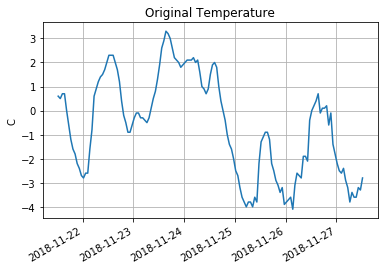

In [28]:
def plot_time_series(fld1, fld2, title, ylabel):
    fig, ax = plt.subplots()
    ax.plot(df_temp["Date"], df_temp["Temperature(C)"])

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    # use a more precise date string for the x axis locations in the
    # toolbar
    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid()

# Load data 
df_raw = pd.read_csv(f"{PATH}measurements.csv", low_memory=False,
                   parse_dates=["Date"])

df_temp = df_raw[["Date", "Temperature(C)"]]
df_hum = df_raw[["Date", "Humidity(%)"]]

plot_time_series("Date", "Temperature(C)", "Original Temperature", "C")

## Stationarity
In order for our standard time series models (SARIMA) to work. Our series has to be stationary. It means that all of our measurements come from the same distribution. In more concrete terms the series needs to satisfy three conditions:

**(i)** The expected value does not depend on time:
    $$ E(x_t) = \mu, \; \; \text{for all}\ t \in T $$

**(ii)** The variance is finite and does not depend on time:
    $$ var(x_t) = \sigma² < \infty, \; \; \text{for all}\ t \in T $$ 
    
**(iii)** The covariance of $x_t$ and $x_s$ does not depend on the time points t and s. It only depends on the difference of t and s:
    $$ cov(x_t, x_s) = \gamma_{t-s}, \; \; \text{for all}\ t \in T$$


These conditions imply that when we look at a realization of a stationary stochastic process we should not detect:

**1.** Trend (Figure 1 below)

**2.** Systematic changes in variance (Figure 2 below)

**3.** Deterministic seasonality (Figure 3 below)


Our series does have some trend component and seasonality. Therefore we need to stationarize the series before applying any of the time series analysis methods to it.

## Removing trends from time series
Differencing is a technique that can be used to remove trends or seasonal components from a time series.

The difference operator is defined as:

$$ Dx_t = x_t - x_{t-1} $$

This operator can be used to remove a linear trend from the data.
We can get the original series back by adding the substracted values back to the diffed series:

$$ x_t = Dx_t + x_{t-1} $$

We can see this in action from the plots below. Note that there seems to some small difference between the original temp data and the inverted temp data. This is due to the numerical accuracy of our differencing being much higher than my original measument data. We can tackle this problem later, if it becomes and issue.

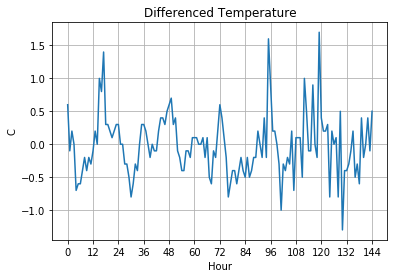

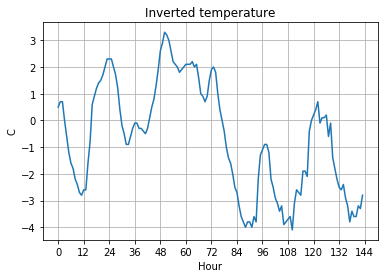

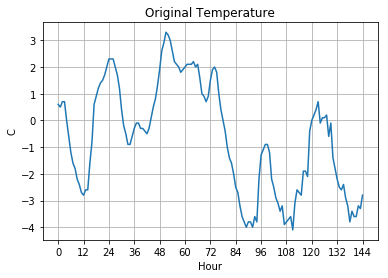

In [73]:
# Computes that difference
def difference(data, lag=1):
    diffed_data = []
    #Let's try to add the first part
    for i in range(0, lag):
        diffed_data.append(data[i])
        
    for t in range(lag, len(data)):
        value = data[t] - data[t - lag]
        diffed_data.append(value)
    return diffed_data

def invert_difference(diffed_data, orig_data, lag=1):
    inverted_data = []
    for t in range(lag, len(diffed_data)):
        value = diffed_data[t] + orig_data[t - lag]
        inverted_data.append(value)
    return inverted_data

def plot_temp(temp_data, title):
    plt.figure()
    plt.plot(temp_data)
    _ = plt.xticks(np.arange(0, 146, 12))
    plt.grid(True)
    plt.title(title)
    plt.ylabel("C")
    plt.xlabel("Hour")
    plt.show()
    
# Extract the raw data
data_values = data.values
temp = data_values[:, 2]
hum = data_values[:, 3]
dates = data_values[:,0]

# Take first order difference to remove linear trend
diff_temp = difference(temp)
plot_temp(diff_temp, "Differenced Temperature")

# Invert that difference and see if we get back the same series 
inverted_temp = invert_difference(diff_temp, temp)
plot_temp(inverted_temp, "Inverted temperature")

# Let's compare to the original data
plot_temp(temp, "Original Temperature")

## Removing Seasonality from a time series
We can use differencing to remove seasonal components from our time series aswell. We set our difference period to be our season length: 

$$ D_{24}x_t = x_t - x_{t-24} $$



We also have to preprocess our data to be dividable by our season lenght or else we will lose some of the series by differencing it by the season length.

From looking at the differenced series below we can quite confidently say that it is now stationary. Therefore let's now start using some time series models to model this data.

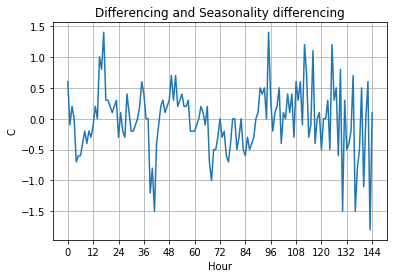

In [74]:
 # DD24
final_temp = difference(diff_temp, lag=24)
plot_temp(final_temp, "Differencing and Seasonality differencing")

## Autocorrelation plots
Good tools for determining, which time series might fit the data well are the autocorrelation and partial autocorrelation plots. In hindsight these might have been good to plot before doing differencing aswell.

### Original data

                     Temperature(C)
datetime                           
2018-11-27 08:27:00            -3.6
2018-11-27 09:27:00            -3.6
2018-11-27 10:27:00            -3.2
2018-11-27 11:27:00            -3.3
2018-11-27 12:27:00            -2.8


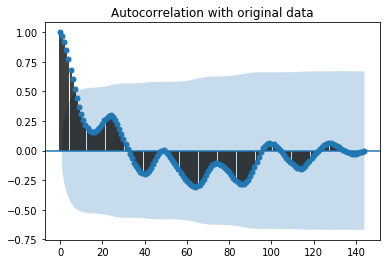

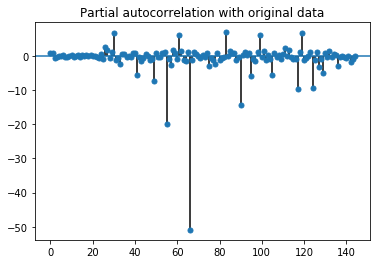

In [81]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

# Make separate data frames for humidity and temp
df_temp = data[['Date','Temperature(C)']]
df_hum = data[['Date', 'Humidity(%)']]

# In order for us to use plot_acf we need to convert the dates into
# datetimes
datetime = pd.to_datetime(data['Date'])
df_temp['datetime'] = datetime
df_hum['datetime'] = datetime

df_temp = df_temp.set_index('datetime')
df_hum = df_hum.set_index('datetime')

df_temp.drop(['Date'], axis=1, inplace=True)
df_hum.drop(['Date'], axis=1, inplace=True)
print(df_temp.tail())

_ = plot_acf(df_temp, title="Autocorrelation with original data") # Return value to remove duplicate plot
_ = plot_pacf(df_temp, title="Partial autocorrelation with original data") # Return value to remove duplicate plot

### Diffed data

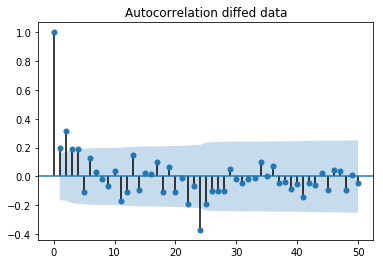

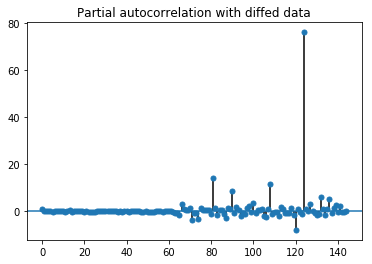

In [88]:
final_df = pd.DataFrame(datetime)
final_df["Temperature(C)"] = final_temp
final_df['datetime'] = datetime
final_df = final_df.set_index('datetime')
final_df.drop(['Date'], axis=1, inplace=True)

_ = plot_acf(final_df, title="Autocorrelation diffed data", lags=50) # Return value to remove duplicate plot
_ = plot_pacf(final_df, title="Partial autocorrelation with diffed data") # Return value to remove duplicate plot

## Let's start trying some AR models